<a href="https://colab.research.google.com/github/hdnl/Chimera/blob/master/PartSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Global Variables

In [ ]:
cfg, object_predictor = None, None
DEFAULT_MODEL_CONFIG = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
jpeg_dir = '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/JPEGImages'

animal_picture_files = [path \
                        for path in \
                        glob.glob('/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/*') \
                        if animal_in_substring(path)]
animal_picture_files

['/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/bird_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/cat_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/cow_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/horse_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/dog_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/sheep_train.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/bird_val.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/cat_val.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/cow_val.txt',
 '/content/drive/Shared drives/PyTorch Hackathon/VOCdevkit/VOC2010/ImageSets/Main/dog_val.txt',
 '/content/drive/Share

## Methods

In [ ]:
def detectron_predictor(model_zoo_config_file=DEFAULT_MODEL_CONFIG, threshold_score = 0.4):
    """If model configuration is not set, set cfg. Return Detectron2 with cfg settings."""
    global cfg
    if not cfg:
        cfg = get_cfg()
        # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
        cfg.merge_from_file(model_zoo.get_config_file(DEFAULT_MODEL_CONFIG))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold_score  # set threshold for this model
        # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(DEFAULT_MODEL_CONFIG)
    return DefaultPredictor(cfg)

def animal_in_substring(string_to_examine, 
                        animals_of_concern=['bird', 'cat', 'cow', 'dog', 
                                            'sheep', 'horse']):
    """Returns boolean indicating if given string has any of the animals_of_concern as a substring."""
    for animal in animals_of_concern:
        if animal in string_to_examine:
            return True
    return False

def display_object_seg_mask(picture_candidates = animal_picture_files, 
                            jpeg_dir = jpeg_dir):
    """Display a picture with a Detectron2 masking detected objects."""
    global object_predictor
    if isinstance(picture_candidates, list): 
        picture_candidate_file = random.choice(picture_candidates)
    else:
        assert isinstance(animal_picture_files, str), 'animal_picture_files should be a list or a string.'
        picture_candidate_file = picture_candidates

    # Load up potential picture candidates
    with open(picture_candidate_file) as f:
        content = f.readlines()
    candidate_files = [x[:x.index(' ')] for x in content if x.strip()[-2] != '-'] 
    # Select random picture
    chosen_picture = random.choice(candidate_files) + '.jpg'
    chosen_picture_path = os.path.join(jpeg_dir, chosen_picture)

    im = cv2.imread(chosen_picture_path)
    # cv2_imshow(im) # show image

    if not object_predictor:
        object_predictor = detectron_predictor()

    outputs = object_predictor(im)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    # print(outputs["instances"].pred_classes)
    # print(outputs["instances"].pred_boxes)
    # Use Visualizer raw the predictions on the image.
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Object Detection Demo

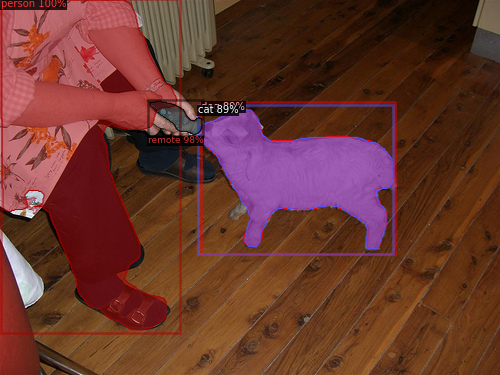

In [ ]:
display_object_seg_mask()

# Dataset Preprocessing for Part Segmentation
Guided by [this project](https://github.com/kevalmorabia97/Object-and-Semantic-Part-Detection-pyTorch)

## Merge part classes

[ipynb](https://github.com/kevalmorabia97/Object-and-Semantic-Part-Detection-pyTorch/blob/master/extra/merge_part_classes.ipynb)

# Could just Object and Semantic Part Detection Model by Morabia et al...
https://github.com/kevalmorabia97/Object-and-Semantic-Part-Detection-pyTorch